# SSGP

Port of GPJax's implementation: https://docs.jaxgaussianprocesses.com/_examples/uncollapsed_vi/

From this paper: https://arxiv.org/abs/1309.6835

In [54]:
import os

# XLA_FLAGS="--xla_force_host_platform_device_count=8"

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax

jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

In [55]:
import sys
sys.path.insert(0, "..")

from pymc_experimental.gp import SVGP

import matplotlib.pyplot as plt
import optax
import numpy as np

import pymc as pm
import pytensor
import pytensor.tensor as pt


# Example data

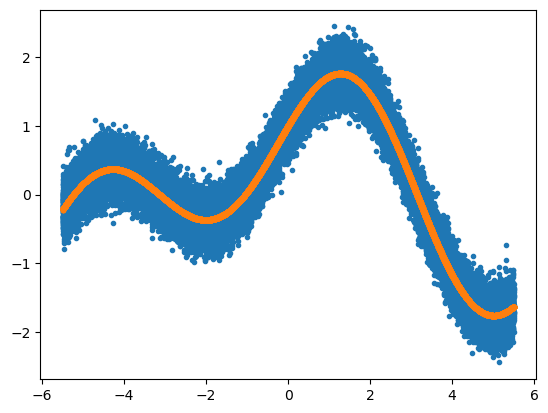

In [56]:
n_data = 50_000
noise = 0.2

low, high = -5.5, 5.5
x = np.sort(np.random.uniform(low, high, n_data))
f = lambda x: np.sin(1 * x) + np.cos(0.5 * x)
signal = f(x)
y = signal + noise * np.random.randn(n_data)

X, y = x[:, None], y[:, None]

plt.plot(x, y, '.');
plt.plot(x, signal, '.');

# Model and fit

In [45]:
with pm.Model() as model:
    pm.Data("X", np.asarray(X))
    pm.Data("y", np.asarray(y))

    eta = pm.Exponential("eta", scale=1.0)
    ell = pm.HalfFlat("ell")
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    c = pm.Exponential("c", scale=10)
    mean_func = pm.gp.mean.Constant(c)

    n_inducing = 50
    #z_init = np.linspace(-5, 5, n_inducing)[:, None]
    z_init = pm.gp.util.kmeans_inducing_points(n_inducing, np.asarray(X))
    z_init = np.sort(z_init, axis=0)
                                              
    sigma = pm.Exponential("sigma", scale=10)

    batch_size = 1024
    svgp = SVGP(
        input_dim=X.shape[1],
        n_data=y.shape[0],
        batch_size=batch_size,
        mean_func=mean_func,
        cov_func=cov_func,
        sigma=sigma,
        z_init=z_init,
        variational_sd_dist=pm.HalfStudentT.dist(sigma=1, nu=6),
    )
            
    initial_point = model.initial_point()
    params = tuple(initial_point.values())

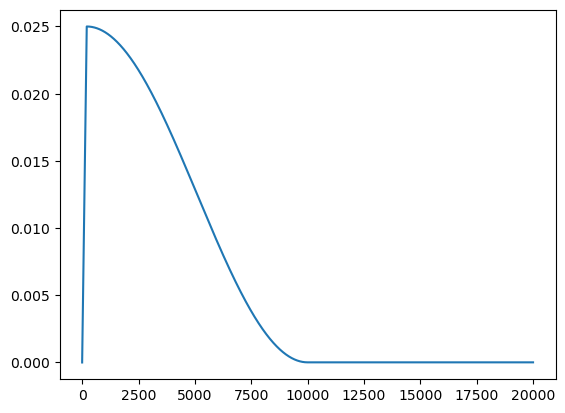

In [50]:
with model:

    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=0.025,
        warmup_steps=200,
        decay_steps=10_000,
        end_value=1e-5,
    )
    plt.plot(schedule(np.arange(n_steps)))
    plt.show()
    
    optimizer = optax.adam(learning_rate=schedule)

    n_steps = 25_000
    params, history = svgp.fit(X, y, optimizer, params=params, n_steps=n_steps)

var_names = model.initial_point().keys()
result = dict(zip(var_names, params))

# Prediction

In [51]:
str_value_transforms = {value.name: (rv.name, model.rvs_to_transforms[rv]) for rv, value in model.rvs_to_values.items()}
var_names = model.initial_point().keys()
results_dict = {name: np.asarray(param) for name, param in zip(var_names, params)}
results = {}
for name_tr, (name, transform) in str_value_transforms.items():
    if transform is None:
        results[name] = results_dict[name_tr]
    else:
        results[name] = transform.backward(pt.as_tensor(results_dict[name_tr])).eval()

In [52]:
t = np.linspace(-6, 7, 200)[:, None]

sigma = results["sigma"] # or set sigma = None to not have likelihood noise

with model:
    f_predict = svgp.compile_pred_func_sd(sigma=sigma)

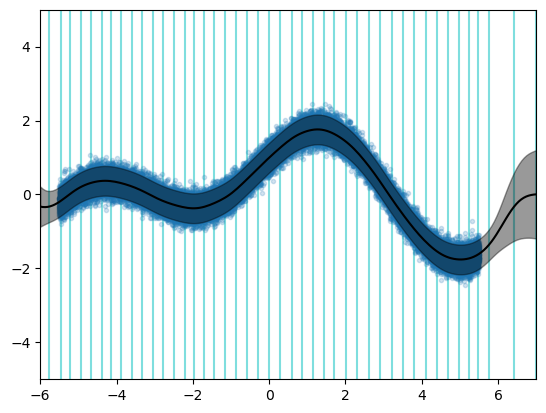

In [68]:
mu, sd = f_predict(t, result)

plt.plot(x, y, '.', zorder=0, alpha=0.2);
plt.plot(t.flatten(), mu, color="k");
plt.fill_between(t.flatten(), mu - 2*sd, mu + 2*sd, color="k", alpha=0.4, zorder=1);
plt.xlim([-6, 7]);
plt.ylim([-5, 5]);

z = results["inducing_inputs"].flatten()
for z_ in z:
    plt.axvline(x=z_, color="c", zorder=-2, alpha=0.5)

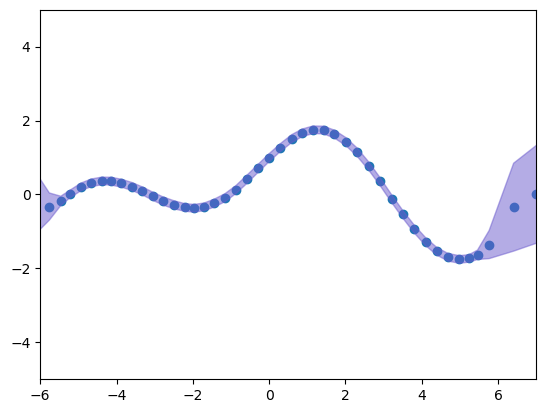

In [90]:
mu = results["variational_mean"].flatten()
plt.scatter(z, mu);

L = pm.expand_packed_triangular(n=50, packed=pt.as_tensor(results["vrc"])).eval()
Sigma = L.dot(L.T)
sd = np.sqrt(np.diag(Sigma))
plt.fill_between(z, mu - 2*sd, mu + 2*sd, color="slateblue", alpha=0.5);
plt.xlim([-6, 7]);
plt.ylim([-5, 5]);